In [147]:
%load_ext autoreload
% autoreload 2
import model_lib


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


UsageError: Line magic function `%` not found.


In [148]:
import os
import json
import numpy as np
import pandas as pd
from pprint import pprint
from itertools import combinations, product

#sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, MinMaxScaler
from sklearn.metrics import precision_recall_curve, auc, roc_curve, recall_score, precision_score, f1_score, confusion_matrix

#graph
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
import shap



In [149]:

# %config IPCompleter.greedy=True
import pandas as pd
import seaborn as sns
import numpy as np
import pickle
from xgboost import XGBClassifier

import matplotlib as matplot
import matplotlib.pyplot as plt
# %matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings, os 
# warnings.filterwarnings("ignore")

# from keras import Sequential
# from keras.models import Model, load_model
# from keras.layers import *
# from keras.callbacks import ModelCheckpoint
# from keras import regularizers
from matplotlib import pyplot as plt

from sklearn.metrics import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA, TruncatedSVD, PCA
from sklearn.svm import LinearSVC

import xgboost
# from mlxtend.classifier import EnsembleVoteClassifier 
import shap
import sklearn.neighbors

from deepod.models import PReNet
from collections import Counter
from modAL.models import ActiveLearner, Committee

import copy

from sklearn.datasets import make_classification
from alipy import ToolBox

import joblib


In [150]:
features = ['Src IP', 'Dst IP','Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts',
       'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min',
       'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max',
       'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s',
       'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s',
       'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std',
       'Pkt Len Var', 'FIN Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt',
       'URG Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg',
       'Bwd Seg Size Avg', 'Subflow Fwd Byts', 'Subflow Bwd Byts',
       'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts',
       'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max',
       'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']
def clean_df(df):
    # Remove the space before each feature names
    
    df.columns = df.columns.str.strip()
    print('dataset shape', df.shape)
    

    # This set of feature should have >= 0 values
    num = df._get_numeric_data()
    num[num < 0] = 0

    zero_variance_cols = []
    for col in df.columns:
        if len(df[col].unique()) == 1:
            zero_variance_cols.append(col)
    # df.drop(zero_variance_cols, axis = 1, inplace = True)
    # print('zero variance columns', zero_variance_cols, 'dropped')
    # print('shape after removing zero variance columns:', df.shape)

    df.replace([np.inf, -np.inf], np.nan, inplace = True)
    print(df.isna().any(axis = 1).sum(), 'rows dropped')
    df.dropna(inplace = True)
    print('shape after removing nan:', df.shape)

    # Drop duplicate rows
    df.drop_duplicates(inplace = True)
    print('shape after dropping duplicates:', df.shape)

    # column_pairs = [(i, j) for i, j in combinations(df, 2) if df[i].equals(df[j])]
    # ide_cols = []
    # for column_pair in column_pairs:
    #     ide_cols.append(column_pair[1])
    # df.drop(ide_cols, axis = 1, inplace = True)
    # print('columns which have identical values', column_pairs, 'dropped')
    # print('shape after removing identical value columns:', df.shape)
    return df

def sample_df(curr_df, anomaly_rate):
    num_benign = len(curr_df.loc[curr_df['Label'] == "BENIGN"])
    num_attack = len(curr_df) - num_benign
    ratio = num_attack / num_benign
    
    if ratio > anomaly_rate:
        sample = anomaly_rate * num_benign / num_attack
        sampled_df = pd.concat([curr_df[curr_df['Label'] == 'BENIGN'], 
                                curr_df[curr_df['Label'] != 'BENIGN'].sample(frac=sample, random_state=42)]) 
    else:
        
        sample = (1/anomaly_rate) * num_attack / num_benign
        sampled_df = pd.concat([curr_df[curr_df['Label'] != 'BENIGN'], 
                                curr_df[curr_df['Label'] == 'BENIGN'].sample(frac=sample, random_state=42)]) 
    
    new_ratio = sampled_df.loc[sampled_df["Label"] == "BENIGN"].shape[0] / sampled_df.loc[sampled_df["Label"] != "BENIGN"].shape[0]
    
    return sampled_df



In [5]:
dataset_csv_path = './Dataset/SimulatedCVE/cicflowmeter_cve/'
folder_names = ['dripper/', 'BENIGN/', 'bonesi/']

def read_csv():
    full_df = pd.DataFrame()
    for folder in folder_names:
        csv_file_names = os.listdir("Dataset/SimulatedCVE/cicflowmeter_cve/" + folder)
        complete_paths = []
        for csv_file_name in csv_file_names:
            print(csv_file_name)
            complete_paths.append(os.path.join(dataset_csv_path+folder, csv_file_name))
        df = pd.concat(map(pd.read_csv, complete_paths), 
                                ignore_index = True)
        df = df[features].copy()
        df["Label"] = folder[:-1]
        full_df = pd.concat([full_df, df], axis=0, ignore_index=True)
    cleaned_df = clean_df(full_df)
    return cleaned_df
full_df = read_csv()
full_df["Label"].value_counts()


merged_20240809091803_ISCX.csv
merged_20240809091912_ISCX.csv
merged_20240809091837_ISCX.csv
merged_20240809091950_ISCX.csv
merged_20240809092024_ISCX.csv
final_merged_1.csv
final_merged_2.csv
final_merged.csv
gm_train_data_0.csv
merged_20240813111613_ISCX.csv
dataset shape (404749, 64)
4835 rows dropped
shape after removing nan: (399914, 64)
shape after dropping duplicates: (285043, 64)


Label
BENIGN     140114
dripper    113205
bonesi      31724
Name: count, dtype: int64

In [6]:
import random

random.seed(42)  # Set seed for random operations
np.random.seed(42)  # Set seed for NumPy operations
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [7]:
flow_df = full_df.drop(columns=["Src IP","Dst IP"], inplace=False, axis=1).copy()
label = flow_df['Label']
le = LabelEncoder()
df = flow_df.copy()
df = sample_df(df, 0.05) # Evaluate Small amounts of Malicious Attack

df['Label'] = df['Label'].apply(lambda x: 0 if x == "BENIGN" else 1)
df['Label'].value_counts()


Label
0    140114
1      7006
Name: count, dtype: int64

# 2D-PCA visualization

In [8]:
# # subsample_df = flow_df.groupby('Label').apply(pd.DataFrame.sample, frac = 0.1).reset_index(drop = True)
# # subsample_df = pd.concat([subsample_df[subsample_df["Label"] != "dos_ge_dr"], subsample_df.groupby('Label').apply(pd.DataFrame.sample, frac=0.1).reset_index(drop=True)])
# X = subsample_df.drop(['Label'], axis=1)
# y = subsample_df['Label']

# # Apply PCA
# pca = PCA(n_components=2, random_state=42)
# pca_results = pca.fit_transform(X)

# # Prepare PCA DataFrame for plotting
# pca_df = pd.DataFrame(pca_results, columns=['dimension 1', 'dimension 2'])
# pca_df['Label'] = y.values
# pca_df['Binary'] = y.apply(lambda x: "malicious" if x != 'BENIGN' else 'BENIGN')


# # Apply t-SNE
# tsne = TSNE(n_components=2, n_jobs=-1, verbose=0, random_state=0, perplexity=20)
# tsne_results = tsne.fit_transform(X)

# # Prepare t-SNE DataFrame for plotting
# tsne_df = pd.DataFrame(tsne_results, columns=['dimension 1', 'dimension 2'])
# tsne_df['Label'] = y.values

# # Create figure and axes for the subplots
# fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # Adjust figsize to fit your needs

# # PCA Plot
# sns.scatterplot(x='dimension 1', y='dimension 2', hue='Label',
#                 palette=sns.color_palette('hls', len(pca_df['Label'].value_counts())),
#                 data=pca_df, ax=axes[0])
# axes[0].set_title('CICIDS2017 15 Classes PCA Projection')
# axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
# axes[0].set_ylim(-10, 10)

# # t-SNE Plot
# sns.scatterplot(x='dimension 1', y='dimension 2', hue='Label',
#                 palette=sns.color_palette('hls', len(tsne_df['Label'].value_counts())),
#                 data=tsne_df, ax=axes[1])
# axes[1].set_title('CICIDS2017 15 Classes T-SNE Projection')
# axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# plt.show()

# XGBoost-ShapValues

Data Processing

In [9]:
# ? Evaluating lack of 
# subsample_df = normalized_df.copy()
# subsample_df["Label"].value_counts()

Label
0    140114
1      7006
Name: count, dtype: int64

In [11]:

labels = df['Label'].copy()
df.drop(columns='Label', axis=1, inplace=True)
print("Before", df.shape)
df = df[:]

df = df.replace([np.inf, -np.inf], np.nan)  # Replace inf/-inf with NaN
df = df.fillna(df.mean())

df.dropna(inplace=True)
df = df.select_dtypes(include=[np.number])
indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
df = df[indices_to_keep]


for i in df.columns:
    df = df[df[i] != "Infinity"]
    df = df[df[i] != np.nan]
    df = df[df[i] != np.inf]
    df = df[df[i] != -np.inf]
    df = df[df[i] != ",,"]
    df = df[df[i] != ", ,"]
    
print(np.any(np.isnan(df)))
print(np.any(np.isfinite(df)))


# Last column turn to binary
# df.iloc[:, -1] = df.iloc[:, -1].apply(lambda x: 1 if x != 0 else 0).astype(int)
#Standardize Dataframe
feature_name = list(df.columns)

scaler = StandardScaler()
feature_name = list(df.columns)
normalized_data = scaler.fit_transform(df)
normalized_df = pd.DataFrame(normalized_data, columns=feature_name)
normalized_df['Label'] = labels.values
df['Label'] = labels.values

print("After", df.shape)




Before (147120, 61)
False
True
After (147120, 62)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(normalized_df.drop(['Label'],axis=1), normalized_df['Label'], test_size=.20, random_state=42)
np.unique(y_train)

array([0, 1])

In [13]:
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
# Initialize the CART classifier
cart_classifier = DecisionTreeClassifier(criterion='entropy', max_depth=15, random_state=4022)
cart_classifier.fit(X_train,y_train)
model_outputs = cart_classifier.predict(X_test)
print(f1_score(model_outputs, y_test))
print(confusion_matrix(model_outputs, y_test))

# Train the classifier on the training data

model = XGBClassifier(objective='binary:logistic')
model.fit(X_train,y_train)
model_outputs = model.predict(X_test)
pred = model.score(X_test, y_test)
print(f1_score(model_outputs, y_test))
print(confusion_matrix(model_outputs, y_test))

DecisionTreeClassifier(criterion='entropy', max_depth=15, random_state=4022)

0.9937706119457678
[[28051     9]
 [    8  1356]]


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

0.9912280701754386
[[28044     9]
 [   15  1356]]


In [14]:
# import joblib
# joblib.dump(model, 'cic_xgb.joblib')
# joblib.dump(scaler, 'cic_scaler.joblib')



In [15]:
scaler.feature_names_in_

array(['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts',
       'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min',
       'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max',
       'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std',
       'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std',
       'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean',
       'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot',
       'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min',
       'Fwd PSH Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'PSH Flag Cnt',
       'ACK Flag Cnt', 'URG Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
       'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Byts',
       'Subflow Bwd Byts', 'Init Fwd Win Byts', 'Init Bwd Win Byts',
       'Fwd Act Data Pkts', 'Fwd Seg S

In [16]:
# new_benign_df = pd.read_csv(os.path.join(dataset_csv_path, "BENIGN/final_merged.csv"))
# new_benign_df.drop(columns=["Unnamed: 0.1"], inplace=True)
# features = ['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts',
#       'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min',
#       'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max',
#       'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std',
#       'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std',
#       'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean',
#       'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot',
#       'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min',
#       'Fwd PSH Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
#       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
#       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'PSH Flag Cnt',
#       'ACK Flag Cnt', 'URG Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
#       'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Byts',
#       'Subflow Bwd Byts', 'Init Fwd Win Byts', 'Init Bwd Win Byts',
#       'Fwd Act Data Pkts', 'Fwd Seg Size Min', 'Active Mean',
#       'Active Std', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Std',
#       'Idle Max', 'Idle Min']

# X = new_benign_df[features]
# X.replace([np.inf, -np.inf], np.nan, inplace = True)
# X.dropna(inplace=True)
# X_scaled = scaler.transform(X)

# import collections

# output = model.predict(X_scaled) 
# counter = collections.Counter(output)
# counter


SHAP

In [17]:
# explainer = shap.Explainer(model)
# shap_values = explainer(X_train)
# np.shape(shap_values.values)

In [18]:
# shap.plots.bar(shap_values, max_display=15)
# plt.show()

# shap.plots.beeswarm(shap_values, max_display=14)
# plt.show()

# Global Model

### Functions

In [8]:
def get_optimal_threshold(precision, recall, thresholds):
    with np.errstate(divide='ignore', invalid='ignore'):
        f1_scores = 2 * (precision * recall) / (precision + recall)
        f1_scores[np.isnan(f1_scores)] = 0  # Replace NaN values with 0    
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

def get_optimal_threshold(precision, recall, thresholds):
    with np.errstate(divide='ignore', invalid='ignore'):
        f1_scores = 2 * (precision * recall) / (precision + recall)
        # f1_scores[np.isnan(f1_scores)] = 0  # Replace NaN values with 0    
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold
  
def eval_accuracy_from_scores(anomaly_scores, y_test):
    fpr, tpr, _ = roc_curve(y_test, anomaly_scores)
    precision, recall, thresholds = precision_recall_curve(y_test, anomaly_scores)
    opt_threshold = get_optimal_threshold(precision, recall, thresholds)
    pred = np.where(anomaly_scores > opt_threshold, 1,0)
    f1 = f1_score(y_test, pred)
    conf_matrix = confusion_matrix(y_test, pred)
    print(f"F1 Score: {f1:.4f}")
    print(conf_matrix)
    
    
    
def set_supervised_label(supervision_rate, y):
        idx = np.where(y_train == 1)[0]
        y = np.zeros_like(y.values)
        if supervision_rate == 0:
            print(f"UNSUPERVISED, Sampling Rate ")
            y[idx[:2]] = 1
        else:
            print(f"SEMI SUPERVISED, Sampling Rate, Supervision = {supervision_rate}")
            idx = np.random.choice(idx, size=int(supervision_rate * len(idx)), replace=False)
            y[idx] = 1
        return y

# Real World AL

### Initial LM Training (GM Pretrained) # TODO: Capture Mix Data with new attack and evaluate

In [143]:
import numpy as np
from flask import Flask, request, jsonify
import pandas as pd
from io import StringIO
import joblib
from sklearn.preprocessing import StandardScaler
from deepod.models import PReNet
from itertools import combinations
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc, roc_curve, recall_score, precision_score, f1_score, confusion_matrix
from xgboost import XGBClassifier
from alipy import ToolBox

features = ['Src IP', 'Dst IP','Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts',
       'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min',
       'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max',
       'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s',
       'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s',
       'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std',
       'Pkt Len Var', 'FIN Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt',
       'URG Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg',
       'Bwd Seg Size Avg', 'Subflow Fwd Byts', 'Subflow Bwd Byts',
       'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts',
       'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max',
       'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']


def clean_df(df):
    # Remove the space before each feature names
    df.columns = df.columns.str.strip()
    print('dataset shape', df.shape)

    # This set of feature should have >= 0 values
    num = df._get_numeric_data()
    num[num < 0] = 0

    df.replace([np.inf, -np.inf], np.nan, inplace = True)
    print(df.isna().any(axis = 1).sum(), 'rows dropped')
    df.dropna(inplace = True)
    print('shape after removing nan:', df.shape)

    # Drop duplicate rows
    df.drop_duplicates(inplace = True)
    print('shape after dropping duplicates:', df.shape)
    return df

def sample_df(curr_df, anomaly_rate):
    num_benign = len(curr_df.loc[curr_df['Label'] == "BENIGN"])
    num_attack = len(curr_df) - num_benign
    ratio = num_attack / num_benign
    
    if ratio > anomaly_rate:
        sample = anomaly_rate * num_benign / num_attack
        sampled_df = pd.concat([curr_df[curr_df['Label'] == 'BENIGN'], 
                                curr_df[curr_df['Label'] != 'BENIGN'].sample(frac=sample, random_state=42)]) 
    else:
        
        sample = (1/anomaly_rate) * num_attack / num_benign
        sampled_df = pd.concat([curr_df[curr_df['Label'] != 'BENIGN'], 
                                curr_df[curr_df['Label'] == 'BENIGN'].sample(frac=sample, random_state=42)]) 
    
    new_ratio = sampled_df.loc[sampled_df["Label"] == "BENIGN"].shape[0] / sampled_df.loc[sampled_df["Label"] != "BENIGN"].shape[0]
    
    return sampled_df

def read_csv(folder_names = ['dripper/', 'BENIGN/', 'bonesi/']):
    full_df = pd.DataFrame()
    dataset_csv_path = './Dataset/SimulatedCVE/cicflowmeter_cve/'
    for folder in folder_names:

        csv_file_names = os.listdir("Dataset/SimulatedCVE/cicflowmeter_cve/" + folder)
        complete_paths = []
        for csv_file_name in csv_file_names:
            complete_paths.append(os.path.join(dataset_csv_path+folder, csv_file_name))
        print(complete_paths)
        df = pd.concat(map(pd.read_csv, complete_paths), 
                                ignore_index = True)
        if folder == 'training_data/gm/': #Avoid Dst IP and Src IP when loading from training folder
            df = df[features[2:]].copy()
        else:
            df = df[features].copy()
        print(folder[:-1])
        df["Label"] = folder[:-1]
        df["Label"] = df["Label"].apply(lambda x: 0 if x == "BENIGN" else 1)
        full_df = pd.concat([full_df, df], axis=0, ignore_index=True)
    label = full_df["Label"]    
    
    cleaned_df = clean_df(full_df)
    # Drop String Columns
    cleaned_df = cleaned_df[features]
    cleaned_df["Label"] = label
    cleaned_df.to_csv("x.csv")
    return cleaned_df
  
def validated_req_schema(flow_data):
  df_pruned = flow_data[features]
  return df_pruned  

def get_optimal_threshold(precision, recall, thresholds):
    with np.errstate(divide='ignore', invalid='ignore'):
        f1_scores = 2 * (precision * recall) / (precision + recall)
        f1_scores[np.isnan(f1_scores)] = 0  # Replace NaN values with 0    
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold
  
def eval_accuracy(clf, X_test, y_test):
    anomaly_scores = clf.decision_function(X_test.to_numpy())
    print("AASDDAS",anomaly_scores)
    fpr, tpr, _ = roc_curve(y_test, anomaly_scores)
    precision, recall, thresholds = precision_recall_curve(y_test, anomaly_scores)
    opt_threshold = get_optimal_threshold(precision, recall, thresholds)
    pred = np.where(anomaly_scores > opt_threshold, 1,0)
    f1 = f1_score(y_test, pred)
    conf_matrix = confusion_matrix(y_test, pred)
    print(f"F1 Score: {f1:.4f}")
    print(conf_matrix)
    return opt_threshold
def get_avail_filename(folder,filename):
    filenumber = 0
    filepath = os.path.join(folder,f"{filename}_{filenumber}.csv")
    while os.path.exists(filepath):
        filenumber+=1
        filepath = os.path.join(folder, f"{filename}_{filenumber}.csv")  
    print(filepath)  
    return filepath

def load_data(train_folder,scaler=None):
    full_df = read_csv(train_folder)
    # validated_df = validated_req_schema(full_df)
    label = full_df["Label"].values
    full_df.drop(columns=["Src IP", "Dst IP", "Label"], axis=1, inplace=True)
    columns = full_df.columns
    if scaler != None:
        normalized_data = scaler.transform(full_df)
        normalized_df = pd.DataFrame(normalized_data, columns = columns)
    else:
        normalized_df = full_df.copy()
    X_train, X_test, y_train, y_test = train_test_split(normalized_df, label, shuffle=True, stratify=label,
                                                        test_size=0.2, random_state=4022)
    return X_train, X_test, y_train, y_test    

    
    
class Global_Model():
  def __init__(self, train_folder = ['dripper/', 'BENIGN/', 'bonesi/', 'training_data/gm/']):
    self.scaler = joblib.load('cic_scaler.joblib')
    self.train_folder = train_folder

    self.model, self.opt_threshold = self.load_model()
    
    
  def load_data(self,scaler=None):
    full_df = read_csv(self.train_folder)
    # validated_df = validated_req_schema(full_df)
    label = full_df["Label"].values
    full_df.drop(columns=["Src IP", "Dst IP", "Label"], axis=1, inplace=True)
    columns = full_df.columns
    if scaler != None:
        normalized_data = scaler.transform(full_df)
        normalized_df = pd.DataFrame(normalized_data, columns = columns)
    else:
        normalized_df = full_df.copy()
    X_train, X_test, y_train, y_test = train_test_split(normalized_df, label, shuffle=True, stratify=label,
                                                        test_size=0.2, random_state=4022)
    return X_train, X_test, y_train, y_test    
    # TODO: New Data Handling - Append the data to the gm_training.csv
    
  def load_model(self): # Load the model through training since pytorch isn't supported
    model = PReNet
    clf = model(epochs=1, device='cuda')
    X_train, X_test, y_train, y_test = self.load_data(self.scaler)
    clf.fit(X_train.to_numpy()[:], y_train[:])
    
    opt_threshold = eval_accuracy(clf, X_test, y_test)
    return clf, opt_threshold
            
      
  def perform_inference(self, X):
    X_scaled = self.scaler.transform(X) # ! Add Scaler
    anomaly_scores = self.model.decision_function(X_scaled)
    output = np.where(anomaly_scores > self.opt_threshold, 1,0)
    print(np.unique(output)) 
    return output

  def update_data(self,X):
    #Write a new CSV FIle
    folder = self.train_folder[-1]
    filename = get_avail_filename(folder, "gm_train_data")
    filepath = os.path.join("Dataset/SimulatedCVE/cicflowmeter_cve/", filename)
    X.to_csv(filepath, index=False)
    
    print(f"Added {filepath} as New GM Training Data")
      
  def retrain_gm(self, X):
    X_scaled = self.scaler.transform(X)

class Local_Model():
    def __init__(self, gm):
        self.model = XGBClassifier(objective='binary:logistic')
        self.train_folder = "./Dataset/SimulatedCVE/cicflowmeter_cve/training_data/lm/"
        self.model_path = "./cic_xgb.joblib"
        self.state = 0 #0: OFF, 1: ON, 2: HYBRID
        self.scaler = joblib.load('./cic_scaler.joblib')
        self.global_model = gm #Replace With HTTP API
        self.load_model()
    def load_model(self):
        # self.model = joblib.load(self.model_path)
        known_df = self.load_known_df()
        y_known = known_df["Label"]
        X_known = known_df.drop(columns=["Label"], inplace=False)
        X_known = X_known[features[2:]]
        X_known_scaled = self.scaler.transform(X_known)
        self.model.fit(X_known_scaled, y_known)
        
    def load_known_df(self):
        known_df = pd.DataFrame()
        training_data_list = os.listdir(self.train_folder)
        training_data_list.sort(reverse=True)
        # known_df =  pd.read_csv(os.path.join(self.train_folder,training_data_list[0]))
        # print(training_data_list[0])
        if len(training_data_list) > 0:
            print(training_data_list)
            for training_data in training_data_list:
                curr_df = pd.read_csv(os.path.join(self.train_folder,training_data))
                known_df = pd.concat([known_df, curr_df], axis=0, ignore_index=True)      
        # known_df.drop(columns=["Src IP", "Dst IP"], inplace=True)
        return known_df  
                
    def retrain_model(self, X_new, y_new=None, threshold = 0.2, update_gm = False): #Select Most Important Data and Upload Newly Recorded Data
        # TODO: Use AL to Select Prerecorded Data
        known_df = self.load_known_df()
        filtered_new_data, informative_score_list, updated_model = self.select_data(known_df, X_new, threshold, y_new)
        # labeled_new_data = self.upload_gm(filtered_new_data)
        if update_gm:
            filtered_new_data["Label"] = 0
            self.global_model.update_data(filtered_new_data)
        # TODO: After updating return the labels or recall the function
        else:
            self.append_training_data(filtered_new_data)
            # Update the model        
            self.model = updated_model # ! If update_gm, should replace the previous record for AL to work
        return informative_score_list
        
    def upload_gm(self, X_query): 
        # X_query_scaled = self.scaler.transform(X_query)
        pseudo_label = self.global_model.perform_inference(X_query)
        X_query_df = pd.DataFrame(X_query, columns=features[2:])
        X_query_df["Label"] = pseudo_label
        return pseudo_label
    def select_data(self, known_df, X_new, threshold, y_new):
        round = 10
        informative_score_list = []
        y_new = np.ones(X_new.shape[0]) * 2 if y_new is None else y_new
        model = self.model
        
        X_known = known_df.drop(columns=["Label"], inplace = False).copy()
        y_known = known_df["Label"]
        # X_known.drop(columns=["Src IP", "Dst IP"], inplace=True)
        X = pd.concat([X_known, X_new], ignore_index=True)
        y = np.concatenate([y_known, y_new]).astype(int)
        print(y)
        label_ind = np.arange(len(X_known))
        print("Size of Label Index", len(X_known))
        unlab_ind = np.arange(len(X_known), len(X))

        divided_arrays = np.array_split(unlab_ind, round)
        
        alibox_new = ToolBox(X=X, y=y, query_type='AllLabels', saving_path=None,) 
        alibox_new.split_AL(test_ratio=0.1, initial_label_rate=0.1, split_count=10)     
        strategy_name = "QueryInstanceUncertainty"
        strategy = alibox_new.get_query_strategy(strategy_name=strategy_name) #TODO Replace Alibox with a single function
        for i in range(round):
            batch_size = 10000 
            print(f"Round {i}")
            # Use AL to Select Data
            select_ind, informative_score = strategy.select(label_index=label_ind, unlabel_index=divided_arrays[i], 
                                                            threshold=threshold, custom = True, model=model, batch_size=batch_size)
            print(select_ind)
            batch_size = min(batch_size, np.shape(select_ind)[0] ) #Limit up to 30 000 per query
            print(batch_size)
            # Upload Data to GM
            idx_to_query = select_ind[:batch_size]
            if len(idx_to_query) > 0:
                if 2.0 in y_new: 
                    pseudo_labels = self.upload_gm(X.iloc[idx_to_query]) 
                    y[idx_to_query] = pseudo_labels 
                else: # ? Set GM to be 100% Accurate
                    pseudo_labels = y[idx_to_query]
                    # y[idx_to_query] = pseudo_labels
                print(f"New Label Counts: {Counter(y[select_ind[:batch_size]])}")    
                label_ind = np.concatenate([label_ind, select_ind[:batch_size]])# label_ind.update(select_ind)
                mask = np.where(np.isin(unlab_ind, select_ind[:batch_size], invert=True)) # unlab_ind.difference_update(select_ind)
                unlab_ind = unlab_ind[mask]
                
                print(f"Added {batch_size} Shape of Label_ind: {np.shape(label_ind)}")  
                #Update The Model
                X_scaled = self.scaler.transform(X.iloc[label_ind]) 
                print("Number of duplicates", len(label_ind) - len(np.unique(label_ind)))
                model = self.model
                print(f"np.unique: {np.unique(y[label_ind])}")
                model.fit(X=X_scaled, y=y[label_ind]) 
            else:
                print("No Data Added")
            print(informative_score[:100])
            informative_score_list.append(informative_score)
        merged_train_df = pd.DataFrame(X.iloc[label_ind], columns = features[2:])
        merged_train_df["Label"] = y[label_ind]
        new_train_df = merged_train_df.iloc[len(X_known):]
        return new_train_df, informative_score_list, model
        
    def perform_inference(self, X):
            X_scaled = self.scaler.transform(X) # ! Add Scaler
            output = self.model.predict(X_scaled) 
            print(np.unique(output)) 
            return output
    def append_training_data(self,new_train_df):
        #Write a new CSV FIle
        folder = self.train_folder
        filepath = get_avail_filename(folder, "lm_train_data")
        new_train_df.to_csv(filepath, index=False)
        print(f"Added {filepath} as New LM Training Data")
    def compress_training_data(self):
        pass


In [144]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Label'],axis=1), df['Label'], test_size=.20, random_state=42)
np.unique(y_train)

array([0, 1])

In [106]:
# gm = Global_Model(['dripper/', 'BENIGN/', 'bonesi/'])

['./Dataset/SimulatedCVE/cicflowmeter_cve/dripper/merged_20240809091803_ISCX.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/dripper/merged_20240809091912_ISCX.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/dripper/merged_20240809091837_ISCX.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/dripper/merged_20240809091950_ISCX.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/dripper/merged_20240809092024_ISCX.csv']
dripper
['./Dataset/SimulatedCVE/cicflowmeter_cve/BENIGN/final_merged_1.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/BENIGN/final_merged_2.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/BENIGN/final_merged.csv']
BENIGN
['./Dataset/SimulatedCVE/cicflowmeter_cve/bonesi/gm_train_data_0.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/bonesi/merged_20240813111613_ISCX.csv']
bonesi
dataset shape (404749, 64)
4835 rows dropped
shape after removing nan: (399914, 64)
shape after dropping duplicates: (285043, 64)
Start Training...
ensemble size: 1
DualInputNet(
  (enc_net): MLPnet(
    (netw

testing: 100%|██████████| 891/891 [00:07<00:00, 118.59it/s]


AASDDAS [1.81393719 1.70342791 5.99638224 ... 6.02717447 5.81151915 1.90479529]
F1 Score: 0.9591
[[27789   234]
 [ 2061 26925]]


In [145]:
# ! When training 10 rounds, the informative score doesnt change 
# ! Global Model isn't accurate?
lm = Local_Model(gm)

['lm_train_data_1.csv', 'lm_train_data_0.csv']


In [146]:
# TODO: Fix StandardScaler was fitted with feature
# informative_score_list = lm.retrain_model(X_train, y_new = y_train.values, threshold = 0.05)
informative_score_list = lm.retrain_model(X_train, y_new = None, threshold = 0.05)

['lm_train_data_1.csv', 'lm_train_data_0.csv']
[1 1 0 ... 2 2 2]
Size of Label Index 8
Round 0
[ 2985  2986  2987  2988  2989  2990  2991  2992  2993  2974  2994  2973
  2971  2952  2953  2954  2955  2956  2957  2958  2959  2960  2961  2962
  2963  2964  2965  2966  2967  2968  2969  2970  2972  3041  2995  2997
  3021  3022  3023  3024  3025  3026  3027  3028  3029  3030  3031  3032
  3033  3034  3035  3036  3037  3038  3039  3020  2996  3019  3017  2998
  2999  3000  3001  3002  3003  3004  3005  3006  3007  3008  3009  3010
  3011  3012  3013  3014  3015  3016  3018  3317  3133  3135  3251  3252
  3253  3254  3255  3256  3257  3258  3259  3260  3261  3262  3263  3264
  3265  3266  3267  3268  3269  3250  3270  3249  3247  3228  3229  3230
  3231  3232  3233  3234  3235  3236  3237  3238  3239  3240  3241  3242
  3243  3244  3245  3246  3248  3227  3271  3273  3297  3298  3299  3300
  3301  3302  3303  3304  3305  3306  3307  3308  3309  3310  3311  3312
  3313  3314  3315  3296  327

testing: 100%|██████████| 16/16 [00:00<00:00, 76.98it/s]


[0 1]
New Label Counts: Counter({0: 958, 1: 42})
Added 1000 Shape of Label_ind: (1008,)
Number of duplicates 0
[    0     1     2 ...  3936  3938 11777]
np.unique: [0 1]
[0.56233514 0.56233514 0.56233514 0.56233514 0.56233514 0.56233514
 0.56233514 0.56233514 0.56233514 0.56233514 0.56233514 0.56233514
 0.56233514 0.56233514 0.56233514 0.56233514 0.56233514 0.56233514
 0.56233514 0.56233514 0.56233514 0.56233514 0.56233514 0.56233514
 0.56233514 0.56233514 0.56233514 0.56233514 0.56233514 0.56233514
 0.56233514 0.56233514 0.56233514 0.56233514 0.56233514 0.56233514
 0.56233514 0.56233514 0.56233514 0.56233514 0.56233514 0.56233514
 0.56233514 0.56233514 0.56233514 0.56233514 0.56233514 0.56233514
 0.56233514 0.56233514 0.56233514 0.56233514 0.56233514 0.56233514
 0.56233514 0.56233514 0.56233514 0.56233514 0.56233514 0.56233514
 0.56233514 0.56233514 0.56233514 0.56233514 0.56233514 0.56233514
 0.56233514 0.56233514 0.56233514 0.56233514 0.56233514 0.56233514
 0.56233514 0.56233514 0.5

testing: 100%|██████████| 16/16 [00:00<00:00, 72.75it/s]


[0 1]
New Label Counts: Counter({0: 917, 1: 83})
Added 1000 Shape of Label_ind: (2008,)
Number of duplicates 0
[    0     1     2 ... 15633 15676 23534]
np.unique: [0 1]
[1.38135111e-05 1.38135111e-05 1.38135111e-05 1.38135111e-05
 5.00402422e-01 1.38135111e-05 1.38135111e-05 5.00402422e-01
 5.00402422e-01 1.38135111e-05 1.38135111e-05 1.38135111e-05
 1.38135111e-05 1.38135111e-05 1.38135111e-05 1.38135111e-05
 1.38135111e-05 1.38135111e-05 1.38135111e-05 1.38135111e-05
 1.38135111e-05 1.38135111e-05 1.38135111e-05 1.38135111e-05
 1.38135111e-05 1.38135111e-05 1.38135111e-05 5.00402422e-01
 1.38135111e-05 1.38135111e-05 1.38135111e-05 1.38135111e-05
 1.38135111e-05 1.38135111e-05 1.38135111e-05 1.38135111e-05
 1.38135111e-05 1.38135111e-05 1.38135111e-05 1.38135111e-05
 1.38135111e-05 1.38135111e-05 1.38135111e-05 1.38135111e-05
 1.38135111e-05 1.38135111e-05 1.38135111e-05 1.38135111e-05
 1.38135111e-05 1.38135111e-05 1.38135111e-05 1.38135111e-05
 1.38135111e-05 1.38135111e-05 1.3813

testing: 100%|██████████| 16/16 [00:00<00:00, 76.49it/s]


[0 1]
New Label Counts: Counter({0: 941, 1: 59})
Added 1000 Shape of Label_ind: (3008,)
Number of duplicates 0
[    0     1     2 ... 27476 27478 35317]
np.unique: [0 1]
[0.50040242 0.50040242 0.50040242 0.50040242 0.50040242 0.50040242
 0.50040242 0.50040242 0.50040242 0.50040242 0.50040242 0.50040242
 0.50040242 0.50040242 0.50040242 0.50040242 0.50040242 0.50040242
 0.50040242 0.50040242 0.50040242 0.50040242 0.50040242 0.50040242
 0.50040242 0.50040242 0.50040242 0.50040242 0.50040242 0.50040242
 0.50040242 0.50040242 0.50040242 0.50040242 0.50040242 0.50040242
 0.50040242 0.50040242 0.50040242 0.50040242 0.50040242 0.50040242
 0.50040242 0.50040242 0.50040242 0.50040242 0.50040242 0.50040242
 0.50040242 0.50040242 0.50040242 0.50040242 0.50040242 0.50040242
 0.50040242 0.50040242 0.50040242 0.50040242 0.50040242 0.50040242
 0.50040242 0.50040242 0.50040242 0.50040242 0.50040242 0.50040242
 0.50040242 0.50040242 0.50040242 0.50040242 0.50040242 0.50040242
 0.50040242 0.50040242 0.5

testing: 100%|██████████| 16/16 [00:00<00:00, 77.11it/s]


[0 1]
New Label Counts: Counter({0: 941, 1: 59})
Added 1000 Shape of Label_ind: (4008,)
Number of duplicates 0
[    0     1     2 ... 39246 39248 47087]
np.unique: [0 1]
[0.67301167 0.67301167 0.67301167 0.67301167 0.67301167 0.67301167
 0.67301167 0.67301167 0.67301167 0.67301167 0.67301167 0.67301167
 0.67301167 0.67301167 0.67301167 0.67301167 0.67301167 0.67301167
 0.67301167 0.67301167 0.67301167 0.67301167 0.67301167 0.67301167
 0.67301167 0.67301167 0.67301167 0.67301167 0.67301167 0.67301167
 0.67301167 0.67301167 0.67301167 0.67301167 0.67301167 0.67301167
 0.67301167 0.67301167 0.67301167 0.67301167 0.67301167 0.67301167
 0.67301167 0.67301167 0.67301167 0.67301167 0.67301167 0.67301167
 0.67301167 0.67301167 0.67301167 0.67301167 0.67301167 0.67301167
 0.67301167 0.67301167 0.67301167 0.67301167 0.67301167 0.67301167
 0.67301167 0.67301167 0.67301167 0.67301167 0.67301167 0.67301167
 0.67301167 0.67301167 0.67301167 0.67301167 0.67301167 0.67301167
 0.67301167 0.67301167 0.6

testing: 100%|██████████| 16/16 [00:00<00:00, 78.29it/s]


[0 1]
New Label Counts: Counter({0: 941, 1: 59})
Added 1000 Shape of Label_ind: (5008,)
Number of duplicates 0
[    0     1     2 ... 51025 51027 58857]
np.unique: [0 1]
[6.10864300e-01 6.10864300e-01 6.10864300e-01 6.10864300e-01
 6.10864300e-01 6.10864300e-01 6.10864300e-01 6.10864300e-01
 6.10864300e-01 6.10864300e-01 6.10864300e-01 6.10864300e-01
 6.10864300e-01 6.10864300e-01 6.10864300e-01 6.10864300e-01
 6.10864300e-01 6.10864300e-01 6.10864300e-01 6.10864300e-01
 6.10864300e-01 6.10864300e-01 6.10864300e-01 6.10864300e-01
 6.10864300e-01 6.10864300e-01 6.10864300e-01 6.10864300e-01
 6.10864300e-01 1.38135111e-05 6.10864300e-01 6.10864300e-01
 6.10864300e-01 6.10864300e-01 6.10864300e-01 6.10864300e-01
 6.10864300e-01 6.10864300e-01 6.10864300e-01 6.10864300e-01
 6.10864300e-01 6.10864300e-01 6.10864300e-01 6.10864300e-01
 6.10864300e-01 6.10864300e-01 6.10864300e-01 6.10864300e-01
 6.10864300e-01 6.10864300e-01 6.10864300e-01 6.10864300e-01
 6.10864300e-01 6.10864300e-01 6.1086

testing: 100%|██████████| 16/16 [00:00<00:00, 81.51it/s]


[0 1]
New Label Counts: Counter({0: 959, 1: 41})
Added 1000 Shape of Label_ind: (6008,)
Number of duplicates 0
[    0     1     2 ... 62767 62770 70627]
np.unique: [0 1]
[3.25082971e-01 1.38135111e-05 1.38135111e-05 3.25082971e-01
 3.25082971e-01 3.25082971e-01 3.25082971e-01 3.25082971e-01
 3.25082971e-01 3.25082971e-01 3.25082971e-01 3.25082971e-01
 3.25082971e-01 3.25082971e-01 3.25082971e-01 3.25082971e-01
 3.25082971e-01 3.25082971e-01 3.25082971e-01 3.25082971e-01
 3.25082971e-01 1.38135111e-05 3.25082971e-01 3.25082971e-01
 3.25082971e-01 3.25082971e-01 3.25082971e-01 3.25082971e-01
 3.25082971e-01 3.25082971e-01 3.25082971e-01 3.25082971e-01
 3.25082971e-01 3.25082971e-01 3.25082971e-01 3.25082971e-01
 3.25082971e-01 3.25082971e-01 3.25082971e-01 3.25082971e-01
 3.25082971e-01 1.38135111e-05 3.25082971e-01 3.25082971e-01
 3.25082971e-01 3.25082971e-01 3.25082971e-01 3.25082971e-01
 3.25082971e-01 3.25082971e-01 3.25082971e-01 3.25082971e-01
 3.25082971e-01 1.38135111e-05 3.2508

testing: 100%|██████████| 16/16 [00:00<00:00, 80.99it/s]


[0 1]
New Label Counts: Counter({0: 958, 1: 42})
Added 1000 Shape of Label_ind: (7008,)
Number of duplicates 0
[    0     1     2 ... 74745 74737 82396]
np.unique: [0 1]
[0.32508297 0.32508297 0.32508297 0.32508297 0.32508297 0.32508297
 0.32508297 0.32508297 0.32508297 0.32508297 0.32508297 0.32508297
 0.32508297 0.32508297 0.32508297 0.23032354 0.32508297 0.32508297
 0.23032354 0.32508297 0.32508297 0.32508297 0.32508297 0.32508297
 0.32508297 0.32508297 0.23032354 0.32508297 0.32508297 0.32508297
 0.32508297 0.32508297 0.32508297 0.32508297 0.32508297 0.32508297
 0.32508297 0.32508297 0.32508297 0.32508297 0.32508297 0.32508297
 0.32508297 0.32508297 0.32508297 0.23032354 0.32508297 0.32508297
 0.32508297 0.32508297 0.32508297 0.32508297 0.32508297 0.32508297
 0.23032354 0.32508297 0.32508297 0.32508297 0.32508297 0.32508297
 0.32508297 0.32508297 0.32508297 0.32508297 0.32508297 0.32508297
 0.32508297 0.32508297 0.23032354 0.32508297 0.32508297 0.32508297
 0.32508297 0.32508297 0.3

In [141]:
lm_out = lm.perform_inference(X_test)
print(accuracy_score(lm_out, y_test))

[0 1]
0.9769235997824904


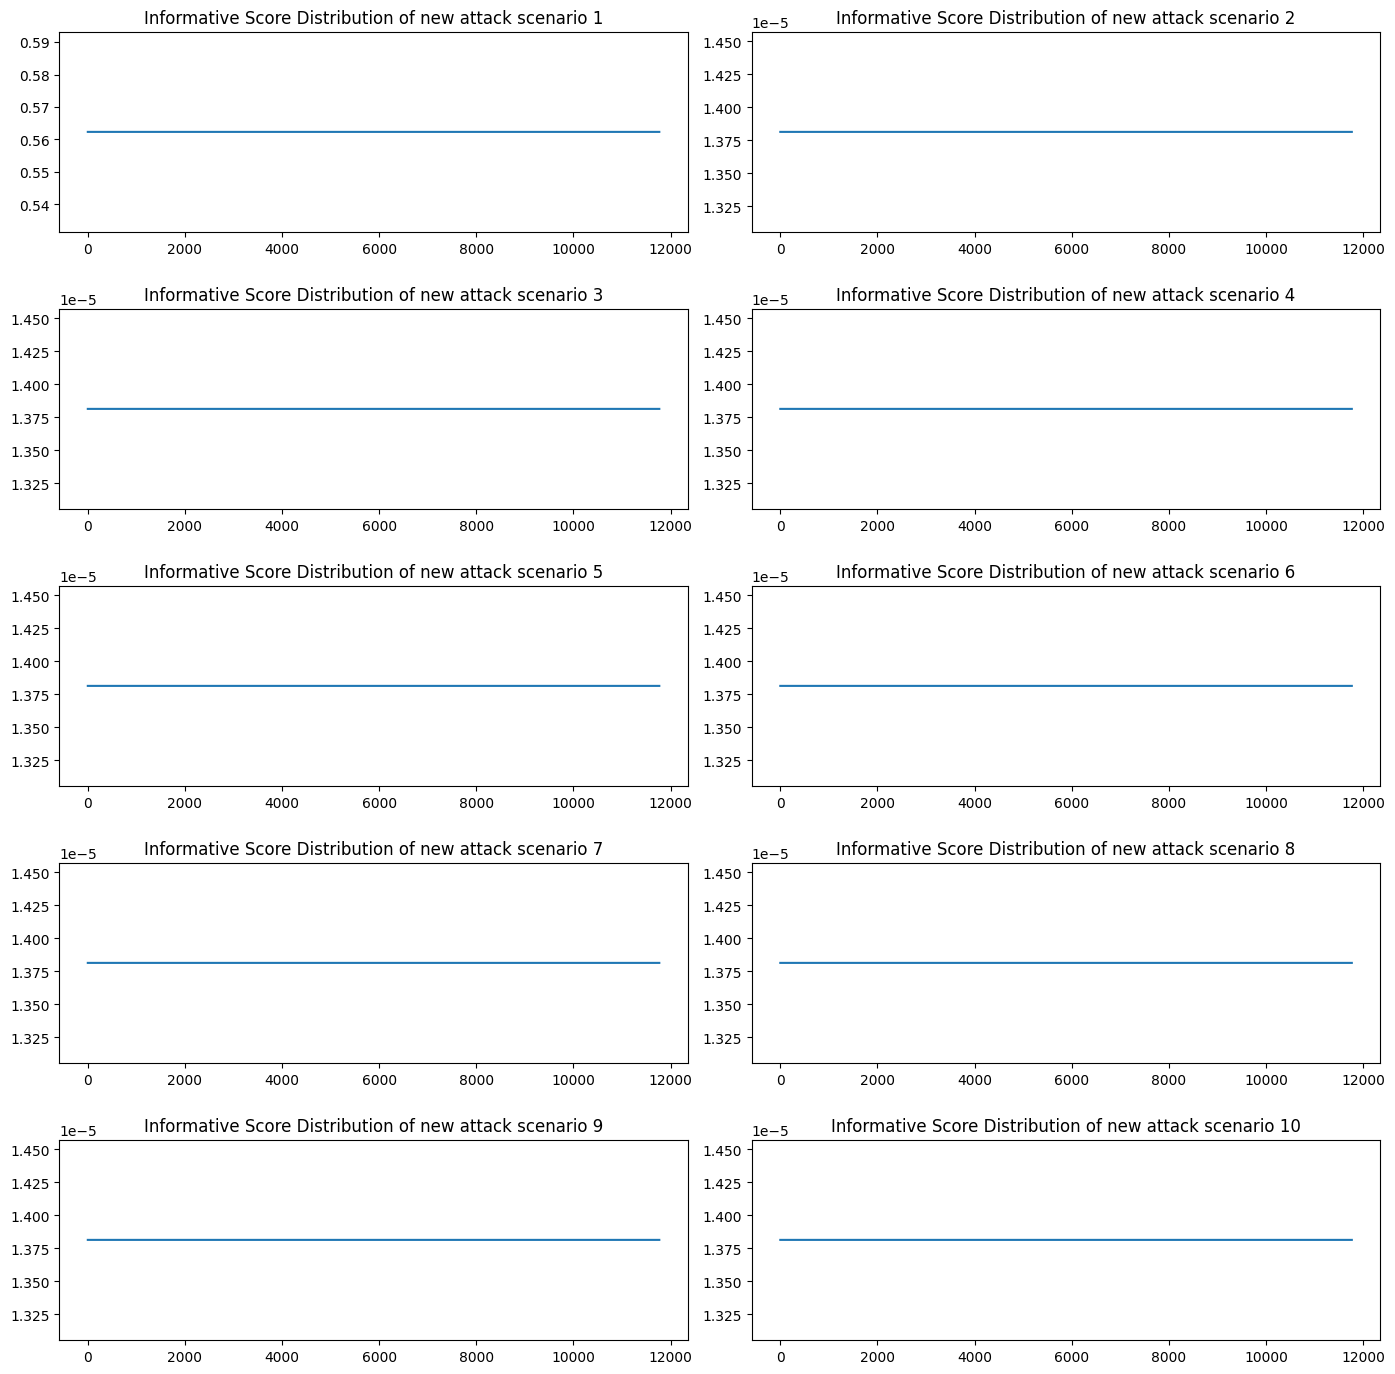

In [142]:
def plot_supporting_scores(informative_score_list, n_times=10, sort=True):

    
    fig, axes = plt.subplots(n_times//2, 2, figsize=(14, 14))  # Create 5x2 subplots
    axes = axes.ravel()  # Flatten the axes array for easy iteration

    for i in range(n_times):
      informative_arr = np.array(informative_score_list[i][:])
      if sort:
        informative_arr = -np.sort(-informative_arr)      
        axes[i].plot(np.arange(len(informative_arr)), informative_arr)
        axes[i].set_title(f"Informative Score Distribution of new attack scenario {i + 1}")

    plt.tight_layout()
    plt.show()
    
plot_supporting_scores(informative_score_list,10)

### New Data

Accuracy against new attack before training


In [ ]:
X_train, X_test, y_train, y_test = load_data(train_folder=["BENIGN/", "goldeneye/"])
counter = Counter(y_train)
counter

['./Dataset/SimulatedCVE/cicflowmeter_cve/BENIGN/final_merged_1.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/BENIGN/final_merged_2.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/BENIGN/final_merged.csv']


BENIGN
['./Dataset/SimulatedCVE/cicflowmeter_cve/goldeneye/merged_20240816133105_ISCX.csv']
goldeneye
dataset shape (237140, 64)
825 rows dropped
shape after removing nan: (236315, 64)
shape after dropping duplicates: (161314, 64)


Counter({0: 112091, 1: 16960})

In [ ]:
lm_out = lm.perform_inference(X_test)
print("Accuracy of LM", accuracy_score(lm_out,y_test))
gm_out = gm.perform_inference(X_test)
print("Accuracy of GM", accuracy_score(gm_out,y_test))

[0 1]
Accuracy of LM 0.896258872392524


testing: 100%|██████████| 505/505 [00:06<00:00, 79.49it/s]

[0 1]
Accuracy of GM 0.9027678765148932


Train LM then GM (if LM doesn't improve train GM)

In [ ]:
# gm_new = Global_Model(['dripper/', 'BENIGN/', 'bonesi/', 'training_data/gm/', 'goldeneye/']) #Reload the model
lm = Local_Model(gm_new)
informative_score_list = lm.retrain_model(X_train,threshold = 0.03,y_new=None, update_gm = False) # !Don't forget to change the update_gm flag


['lm_train_data_2.csv', 'lm_train_data_1.csv', 'lm_train_data_0.csv']
['lm_train_data_2.csv', 'lm_train_data_1.csv', 'lm_train_data_0.csv']
[0 0 0 ... 2 2 2]
Size of Label Index 50008
Round 0
[52325 60568 59622 ... 58568 54697 53172]
5000


testing: 100%|██████████| 79/79 [00:01<00:00, 77.95it/s]


[0 1]
New Label Counts: Counter({0: 3860, 1: 1140})
Added 5000 Shape of Label_ind: (55008,)
Number of duplicates 0
[    0     1     2 ... 58568 54697 53172]
np.unique: [0 1]


KeyboardInterrupt: 

In [ ]:
lm = Local_Model(gm_new)

['lm_train_data_3.csv', 'lm_train_data_2.csv', 'lm_train_data_1.csv', 'lm_train_data_0.csv']


ValueError: Unknown label type: unknown. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

In [ ]:
lm_out = lm.perform_inference(X_test)
print("Accuracy of LM", accuracy_score(lm_out,y_test), "F1_Score", f1_score(lm_out, y_test))
gm_out = gm_new.perform_inference(X_test)
print("Accuracy of GM", accuracy_score(gm_out,y_test), "F1_Score", f1_score(gm_out, y_test))

[0 1]
Accuracy of LM 0.9725382016551468 F1_Score 0.8918721015377105


testing: 100%|██████████| 505/505 [00:06<00:00, 83.76it/s]

[0 1]
Accuracy of GM 0.9696556426866689 F1_Score 0.8815486993345432


## Globally Unseen Attack(GM Active Learning)

In [ ]:
gm_out = gm.perform_inference(X_test)
print("Accuracy of GM", accuracy_score(gm_out,y_test) "F1_Score", f1_score(lm_out, y_test))

testing: 100%|██████████| 505/505 [00:06<00:00, 72.53it/s]

[0 1]
Accuracy of GM 0.9714223723770263


# GM New Atk (Unlabeled)

In [ ]:
gm = Global_Model(['dripper/', 'BENIGN/', 'bonesi/', 'goldeneye']) #Reload the model
gm_out = gm.perform_inference(X_test)
print("Accuracy of GM", accuracy_score(gm_out,y_test),  "F1_Score", f1_score(lm_out, y_test))

['./Dataset/SimulatedCVE/cicflowmeter_cve/dripper/merged_20240809091803_ISCX.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/dripper/merged_20240809091912_ISCX.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/dripper/merged_20240809091837_ISCX.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/dripper/merged_20240809091950_ISCX.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/dripper/merged_20240809092024_ISCX.csv']
dripper
['./Dataset/SimulatedCVE/cicflowmeter_cve/BENIGN/final_merged_1.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/BENIGN/final_merged_2.csv', './Dataset/SimulatedCVE/cicflowmeter_cve/BENIGN/final_merged.csv']
BENIGN
['./Dataset/SimulatedCVE/cicflowmeter_cve/bonesi/merged_20240813111613_ISCX.csv']
bonesi
['./Dataset/SimulatedCVE/cicflowmeter_cve/goldeneye/merged_20240816133105_ISCX.csv']
goldeney
dataset shape (422046, 64)
838 rows dropped
shape after removing nan: (421208, 64)
shape after dropping duplicates: (306243, 64)
Start Training...
ensemble size: 1
DualInputNet(
  (enc_

testing: 100%|██████████| 958/958 [00:08<00:00, 107.97it/s]


F1 Score: 0.9521
[[27825   229]
 [ 2826 30369]]


testing: 100%|██████████| 505/505 [00:07<00:00, 71.61it/s]


[0 1]
Accuracy of GM 0.9714843628924774


In [ ]:
ge_df = pd.read_csv("Dataset/SimulatedCVE/cicflowmeter_cve/goldeneye/merged_20240816133105_ISCX.csv")
ge_unlabeled_df = ge_df.copy()
ge_unlabeled_df["Label"] = 0
ge_unlabeled_df.to_csv("ge_unlabeled.csv")

In [ ]:

informative_score_list = model.retrain_model(X_train, threshold = 0.05, update_gm = True)
plot_supporting_scores(informative_score_list,10)


TypeError: retrain_model() got an unexpected keyword argument 'update_gm'

In [ ]:
lm_out = lm.perform_inference(X_test)
print("Accuracy of LM", accuracy_score(lm_out,y_test))

[0 1]
Accuracy of LM 0.9004742274432012
